In [80]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import IPython

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
from scipy.io.wavfile import write
#import scipy.io.wavfile
from scipy.linalg import hankel
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3

# Useful functions

In [81]:
def load_sound(file):
    return wave.open(file, 'rb')

def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    plt.figure(figsize=(w, h))
    plt.plot(times,x.reshape(len_x))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [82]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    #logz = delta + 1j*2*np.pi*f
    logz = [ delta[i] + 1j*2*np.pi*f[i] for i in range(len(f))]
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

# Open audio file

In [83]:
wavefile = load_sound('ClocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [84]:
IPython.display.Audio('ClocheB.WAV')

In [85]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

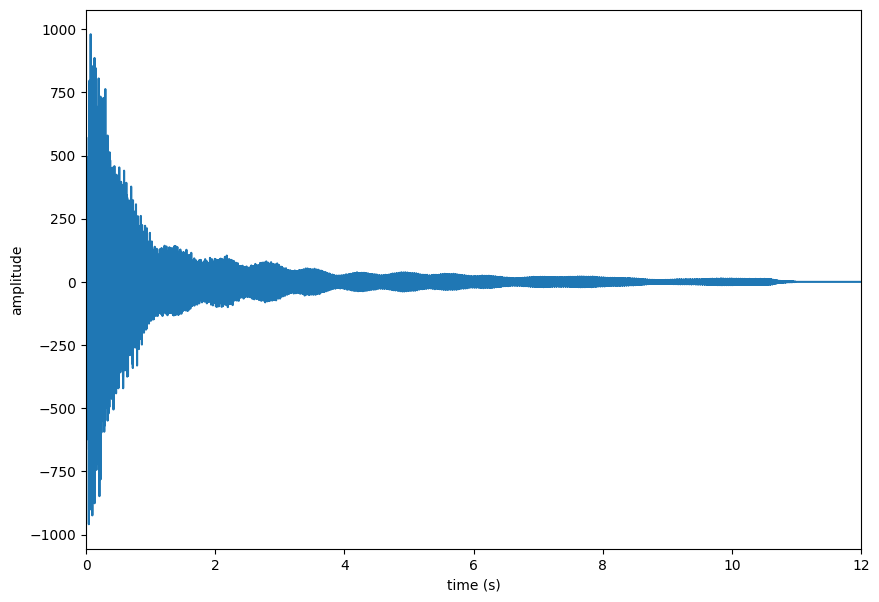

In [86]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

In [87]:
write('new_bell.wav', Fs, np.array(x.reshape(len_x), dtype=np.int16)) # to write a new wave file

#### 3. Synthetic signal

In [88]:
phi = np.array(np.random.uniform(-np.pi, np.pi, 2))
x = Synthesis(N=63, delta=[0, -0.05] , f=[1/4, (1/4) + (1/63)], a=[1, 10], phi=phi)

#### 3.1 Spectral analysis by Fourier Transform

In [89]:
def periodogram(x, zero_padding=False):
    Nfft = len(x)
    if zero_padding:
        Nfft = 1024

    periodogram_values = np.abs(np.fft.fft(x, Nfft))**2 / len(x)
    freq = np.fft.fftfreq(Nfft)

    periodogram_values = periodogram_values
    freq = freq
    return freq, periodogram_values

f, S = periodogram(x, zero_padding=False)
f_pad, S_pad = periodogram(x, zero_padding=True)

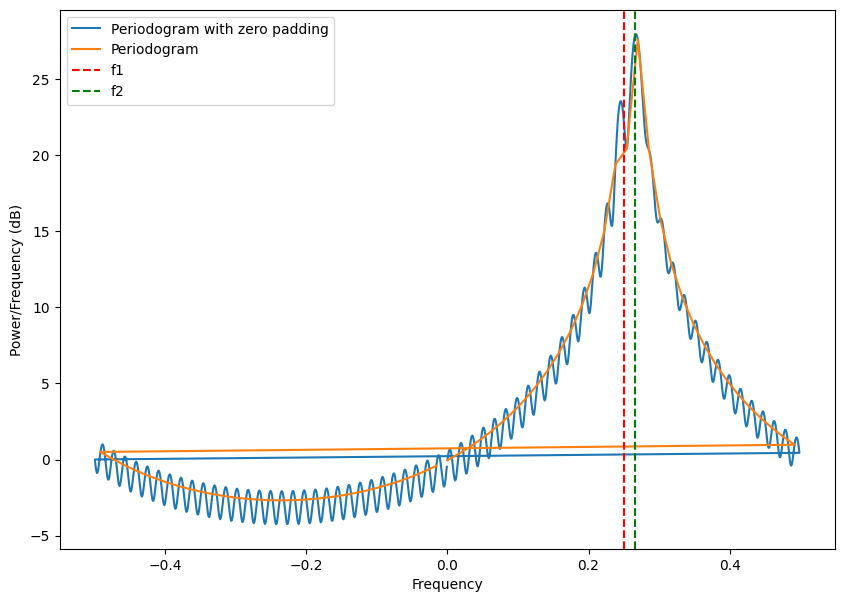

In [90]:
# plot both
plt.figure(figsize=(10, 7))
plt.plot(f_pad, 10*np.log10(S_pad), label='Periodogram with zero padding')
plt.plot(f, 10*np.log10(S), label='Periodogram')
plt.axvline(1/4, color='r', linestyle='--', label='f1')
plt.axvline(1/4 + (1/63), color='g', linestyle='--', label='f2')
plt.xlabel('Frequency')
plt.ylabel('Power/Frequency (dB)')
plt.legend()
plt.show()


    Comparing the accuracy of the two methods in detecting the frequencies of the synthetic signal. We can see that the Periodogram with zero padding is more accurate than the periodogram without zero padding. as for this example we can clearly see that the periodogram with zero padding is able to distinguish the two frequencies of the synthetic signal, but the downside is that it has more variance than the periodogram without zero padding, and we risk to detect frequencies that are not present in the signal, for other examples.

#### 3.2 High resolution methods

##### Computation of the empirical covariance matrix

In [91]:
def emp_cov(x, n):
    """
    Computes the empirical covariance matrix of the data X.
    """
    N = len(x)
    l = N+1-n
    hankel_ = hankel(c = x[0:n], r = x[n-1:n-1+l], )

    Rxx = np.dot(hankel_, hankel_.T.conj()) / l

    return Rxx

##### Estimation of the signal subspace

In [92]:
def signal_subspace(Rxx, K):

    U1, _, _ = np.linalg.svd(Rxx)
    
    return U1[:, :K]

#### 3.2.1 ESPRIT method

##### Estimation of the frequencies and damping factors

In [93]:
def ESPRIT(x, n, K):
    Rxx = emp_cov(x,n)
    W = signal_subspace(Rxx, K)

    W_ = W[1:,:]
    W__ = W[:-1,:]

    phi = (np.linalg.pinv(W__.T.conj() @ W__) @ W__.T.conj() ) @ W_ # np.linalg.pinv(W__) @ W_ # 

    eigenvalues, _ = np.linalg.eig(phi)

    delta = [np.log(np.abs(eigenvalue)) for eigenvalue in eigenvalues]
    frequencies = [np.angle(eigenvalue) / (2 * np.pi) for eigenvalue in eigenvalues]

    return delta, frequencies

#### Estimation of the amplitudes and phases

In [94]:
def LeastSquares(x, delta, f):
    
    # Conctructing Vn
    N = len(x)
    t = np.array(range(N)).reshape(-1, 1)
    temp = np.array([delta[i] + 2j*np.pi*f[i] for i in range(len(f))]).reshape(1, -1)
    
    Vn = np.exp(t @ temp)

    # alpha
    alpha = ( np.linalg.pinv(Vn.T.conj() @ Vn) @ Vn.T.conj() ) @ x # np.linalg.pinv(Vn) @ x

    # amplitudes and phases
    a = np.abs(alpha)
    phi = np.angle(alpha)

    return a, phi

#### Application : 

In [95]:
n = 32
K = 2
len_x = len(x)
x_ = x[K+1:len_x-K+2]
x_ = x[0:63]
delta, frequencies = ESPRIT(x_, n, K)

a, phi_est = LeastSquares(x_, delta, frequencies)

data = {'True parameters': ['[-0.05, 0]', '[0.26587301587, 0.25]', '[10, 1]', str(phi[1] ) +',' + str(phi[0])+']'], 
        'Estimated parameters': [str(delta), str(frequencies), str(a), str(phi_est)]}

# change the name of the lines 
index = ['delta', 'frequencies', 'a', 'phi']

df = pd.DataFrame(data, index=index)
df

,True parameters,Estimated parameters
delta,"[-0.05, 0]","[-0.04999999999999999, -4.440892098500627e-16]"
frequencies,"[0.26587301587, 0.25]","[0.26587301587301587, 0.24999999999999997]"
a,"[10, 1]",[10. 1.]
phi,"-1.7162211040258406,-2.3272052151519502]",[-1.7162211 -2.32720522]


    We can see that we have successfully estimated the different parameters. 

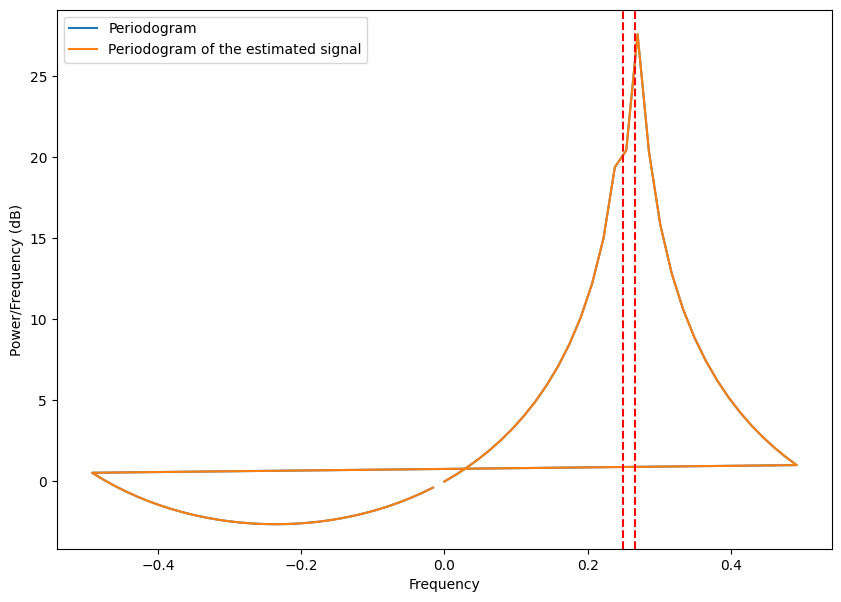

In [96]:
# Estimation of the signal
x_est = Synthesis(N=len(x_), delta=delta, f=frequencies, a=a, phi=phi_est)

f_est, S_est = periodogram(x_est, zero_padding=False)

plt.figure(figsize=(10, 7))
plt.plot(f, 10*np.log10(S), label='Periodogram')
plt.plot(f_est, 10*np.log10(S_est), label='Periodogram of the estimated signal')
plt.axvline(x=1/4, color='r', linestyle='--')
plt.axvline(x=(1/4) + (1/63), color='r', linestyle='--')
plt.xlabel('Frequency')
plt.ylabel('Power/Frequency (dB)')
plt.legend()
plt.show()

    The two periodograms indicates the same frequencies, have exactly the same shape.

#### MUSIC Method

##### MUSIC pseudo-spectrum

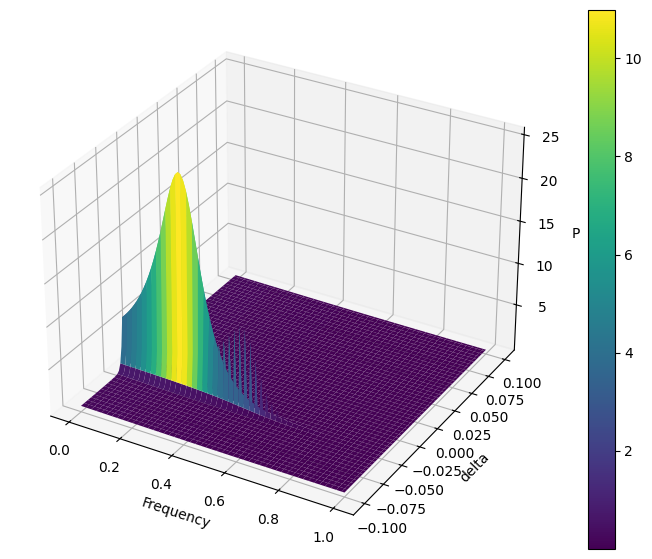

In [97]:
def MUSIC(x, n, K):
    # plot_surface
    Rxx = emp_cov(x, n)
    U, _, _ = np.linalg.svd(Rxx)
    U = U[:, K:]
    W_t_c = U.T.conj()

    f = np.linspace(0, 1, 100)
    delta = np.linspace(-0.1, 0.1, 100)

    P = np.zeros((len(f), len(delta)))
    for i in range(len(f)):
        f_ = f[i]
        for k in range(len(delta)):
            delta_ = delta[k]
            v = np.array([np.exp(1j*2*np.pi*f_*i + delta_*i) for i in range(n)])
            P[i, k] = 1 / (np.linalg.norm(W_t_c @ v)**2)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    X, Y = np.meshgrid(f, delta)

    # Tracer la surface
    surf = ax.plot_surface(X, Y, P, cmap='viridis')
    fig.colorbar(surf)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('delta')
    ax.set_zlabel('P')

    plt.show()

MUSIC(x_, n, 2)

    As expected, the MUSIC method is very accurate. The MUSIC method is able to detect the frequencies and the damping factors of the synthetic signal with a high accuracy.

#### Audio signals

##### Spectral analysis by Fourier transform

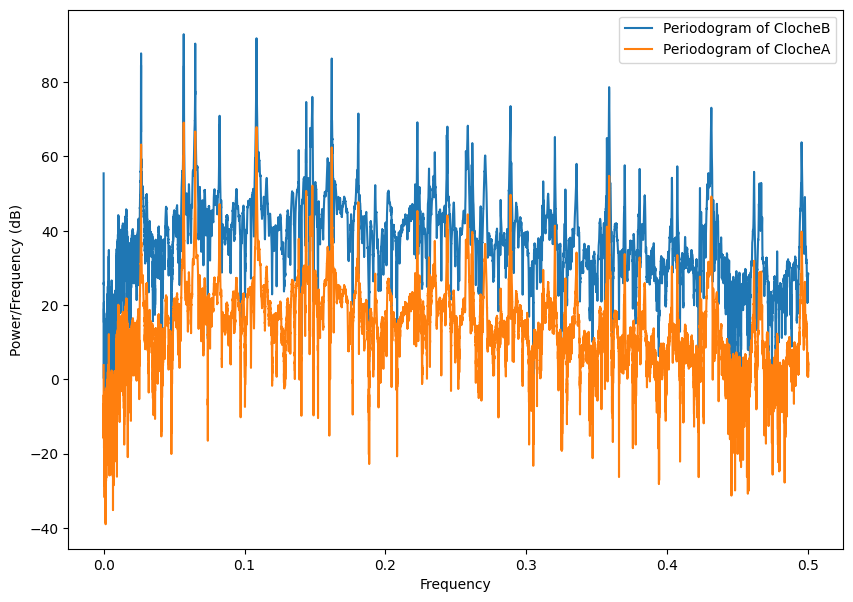

In [98]:
# clocheA
_, data, _, _, _ = read_values('ClocheA.WAV')
clocheA = np.array(data).reshape(-1)

# periodogram
f, S_clocheA = periodogram(clocheA)
f, S_clocheA = f[f>=0], S_clocheA[f>=0]

# clocheB
_, data, _, _, _ = read_values('ClocheB.WAV')

clocheB = np.array(data).reshape(-1)

# periodogram
f_B, S_clocheB = periodogram(clocheB)
f_B, S_clocheB = f_B[f_B>=0], S_clocheB[f_B>=0]
plt.figure(figsize=(10, 7))
plt.plot(f_B, 10*np.log10(S_clocheB), label='Periodogram of ClocheB')
plt.plot(f, 10*np.log10(S_clocheA), label='Periodogram of ClocheA')
plt.xlabel('Frequency')
plt.ylabel('Power/Frequency (dB)')
plt.legend()
plt.show()

    We can see that the periodogram of both have tha same shape, and the peaks are at the same frequencies. Let's compare the series of the frequencies with the values given in the introduction.

The peaks are in frequencies : 
[0.05683510943050304, 0.10849297373876268, 0.06501244830567622, 0.0265841640884611, 0.161880058751836, 0.3587403773034574, 0.14809837807431483, 0.2887798577038866, 0.43126347698365575, 0.18078689959061223, 0.08229423836161548, 0.2226527912330594, 0.25841432544767023, 0.24395554027730035, 0.32026000812525396, 0.49530714501494844]


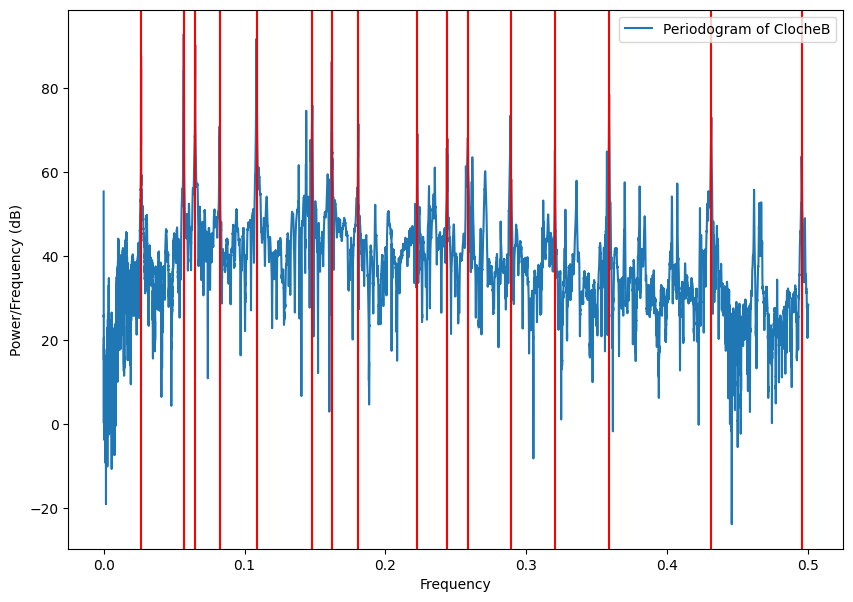

In [99]:
import scipy.signal
peaks, _ = scipy.signal.find_peaks(S_clocheA, height=0)


# Sort peaks based on magnitude
sorted_peaks = sorted(peaks, key=lambda x: S_clocheA[x], reverse=True)

# Initialize list to store selected peaks
selected_peaks = []

min_freq_difference = 0.005
for peak in sorted_peaks:
    frequency = f[peak]
    if all(abs(frequency - selected_freq) >= min_freq_difference for selected_freq in selected_peaks):
        selected_peaks.append(frequency)

    if len(selected_peaks) == 16:
        break

print( "The peaks are in frequencies : ")
print(selected_peaks)

plt.figure(figsize=(10, 7))
plt.plot(f_B, 10*np.log10(S_clocheB), label='Periodogram of ClocheB')
for i in range(len(selected_peaks)):
    plt.axvline(selected_peaks[i], color="red")
plt.xlabel('Frequency')
plt.ylabel('Power/Frequency (dB)')
plt.legend()
plt.show()

In [100]:
fp = selected_peaks[0]
ratios = selected_peaks[1:] / fp
sorted(ratios)[:12]

[0.467741935483871,
 1.1438782991202345,
 1.4479472140762466,
 1.9089076246334313,
 2.6057551319648096,
 2.848240469208211,
 3.180901759530792,
 3.9175219941348978,
 4.29233870967742,
 4.546737536656892,
 5.081011730205279,
 5.634897360703813]

0.5 , 1, 1.2, 1.5, 2, 2.5, 2.6, 2.7, 3,
3.3, 3.7, 4.2, 4.5, 5, 5.9

    We can remark that the ratios are similar ( we observe some little differences, might be due to different imperfections)

##### High resolution methods

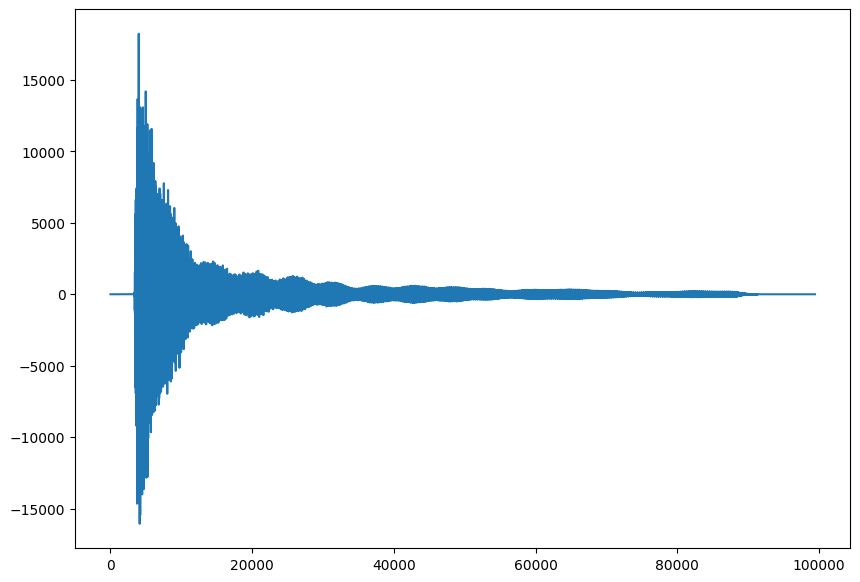

In [101]:
plt.figure(figsize=(10, 7))
plt.plot(np.array(data)[0])
plt.show()

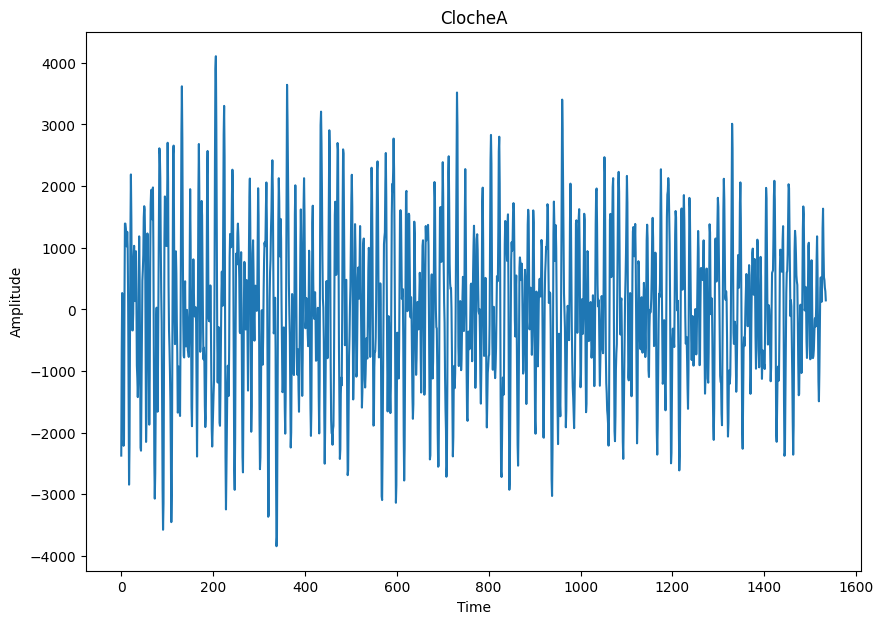

In [102]:
# Parameters
K = 54
n = 512
l = 2*n
N = n + l - 1

# clocheA
_, data, _, _, _ = read_values('ClocheB.WAV')
x_cloche = np.array(data)
x_cloche = x_cloche[0]
x_cloche = x_cloche[10000:10000+N]

# plot the signal
plt.figure(figsize=(10, 7))
plt.plot(x_cloche)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('ClocheA')
plt.show()

In [103]:
# Estimation

delta, frequencies = ESPRIT(x_cloche, n, 16)

a, phi_est = LeastSquares(x_cloche, delta, frequencies)

print('Estimated parameters:')
print('delta:', delta)
print('frequencies:', frequencies)
print('a:', a)
print('phi:', phi_est)


Estimated parameters:
delta: [-0.00017008645555098377, -0.00017008645555098377, -0.000269972938709046, -0.000269972938709046, -0.0006298243115571452, -0.0006298243115571452, -0.0005443648778641704, -0.0005443648778641704, -5.119224967629934e-05, -5.119224967629934e-05, -0.0004395464730097556, -0.0004395464730097556, -0.00017886595908353482, -0.00017886595908353482, -0.0007001712994611993, -0.0007001712994611993]
frequencies: [0.24407466827420632, -0.24407466827420632, 0.16188432594156407, -0.16188432594156407, 0.14385324481980225, -0.14385324481980225, 0.1084954572673303, -0.1084954572673303, 0.06501503207572738, -0.06501503207572738, 0.056856158700735814, -0.056856158700735814, 0.026571184482782242, -0.026571184482782242, 0.0823977297665556, -0.0823977297665556]
a: [ 70.4729006   70.4729006  485.9391012  485.9391012  104.33270106
 104.33270106 548.482332   548.482332   510.93048964 510.93048964
 647.99879086 647.99879086 196.03569633 196.03569633 106.89003927
 106.89003927]
phi: [ 1.5

/home/iliass/.local/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/iliass/.local/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


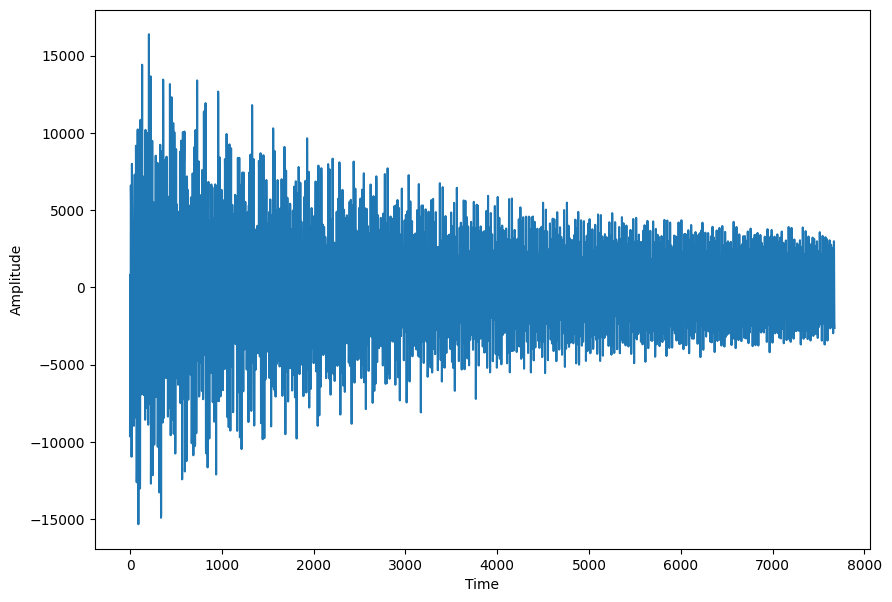

In [104]:
# Synthesis
x_est = Synthesis( N=5*N, delta=delta, f=frequencies, a=a, phi=phi_est)
plt.figure(figsize=(10, 7))
plt.plot(4*x_est)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [105]:
write('new_bell.wav', int(Fs/2), np.array(10*x_est, dtype=np.int16)) # to write a new wave file
IPython.display.Audio('new_bell.wav')

/tmp/ipykernel_22766/2820456572.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  write('new_bell.wav', int(Fs/2), np.array(10*x_est, dtype=np.int16)) # to write a new wave file


    The sound corresponds to the sound expected sound of a bell, and we conclude that spectral analysis using high resolution methods is efficient when it comes to estimating the different parameters of an ESM model.